In [12]:
!pip install pmdarima

## Occupancy analysis with `pmdarima`



In [13]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline

import pmdarima as pm
print(f"Using pmdarima {pm.__version__}")

Using pmdarima 1.8.0


### Import the data



In [14]:
!git clone https://github.com/valwork2021/Hackathon.git

fatal: destination path 'Hackathon' already exists and is not an empty directory.


In [15]:
df = pd.read_csv('/content/Hackathon/insights_product_by_hour.csv')
df

,Sensor Activity By Hour Start of Hour Hour,Sensor Activity By Hour Minutes,Sensor Activity By Hour Minutes.1
0,2019-12-20 18,1380.0,1607.0
1,2019-12-20 19,1005.0,1430.0
2,2019-12-20 20,730.0,696.0
3,2019-12-20 21,421.0,680.0
4,2019-12-20 22,223.0,491.0
...,...,...,...
696,2020-01-18 18,NaN,58.0
697,2020-01-18 19,NaN,45.0
698,2020-01-18 20,NaN,46.0
699,2020-01-18 21,NaN,12.0


In [16]:
df = pd.read_csv('/content/Hackathon/insights_product_by_hour.csv')

df.drop(df.index[[0]], inplace=True)
df.fillna(0, inplace=True)
df.iloc[:, 1] = df.iloc[:, 1].astype(float)
df.iloc[:, 2] = df.iloc[:, 2].astype(float)

#del df['Location Building Name']
df

,Sensor Activity By Hour Start of Hour Hour,Sensor Activity By Hour Minutes,Sensor Activity By Hour Minutes.1
1,2019-12-20 19,1005.0,1430.0
2,2019-12-20 20,730.0,696.0
3,2019-12-20 21,421.0,680.0
4,2019-12-20 22,223.0,491.0
5,2019-12-20 23,264.0,324.0
...,...,...,...
696,2020-01-18 18,0.0,58.0
697,2020-01-18 19,0.0,45.0
698,2020-01-18 20,0.0,46.0
699,2020-01-18 21,0.0,12.0


### Split the data

We'll use 80% of the samples as training data. Note that a time series' train/test split is different from that of a dataset without temporality; order *must* be preserved if we hope to discover any notable trends.

In [17]:
train_len = int(df.shape[0] * 0.8)
train_data, test_data = df[:train_len], df[train_len:]

y_train = train_data.iloc[:, 1]
y_test = test_data.iloc[:, 1].values

print(f"{train_len} train samples")
print(f"{df.shape[0] - train_len} test samples")

560 train samples
140 test samples


### Pre-modeling analysis



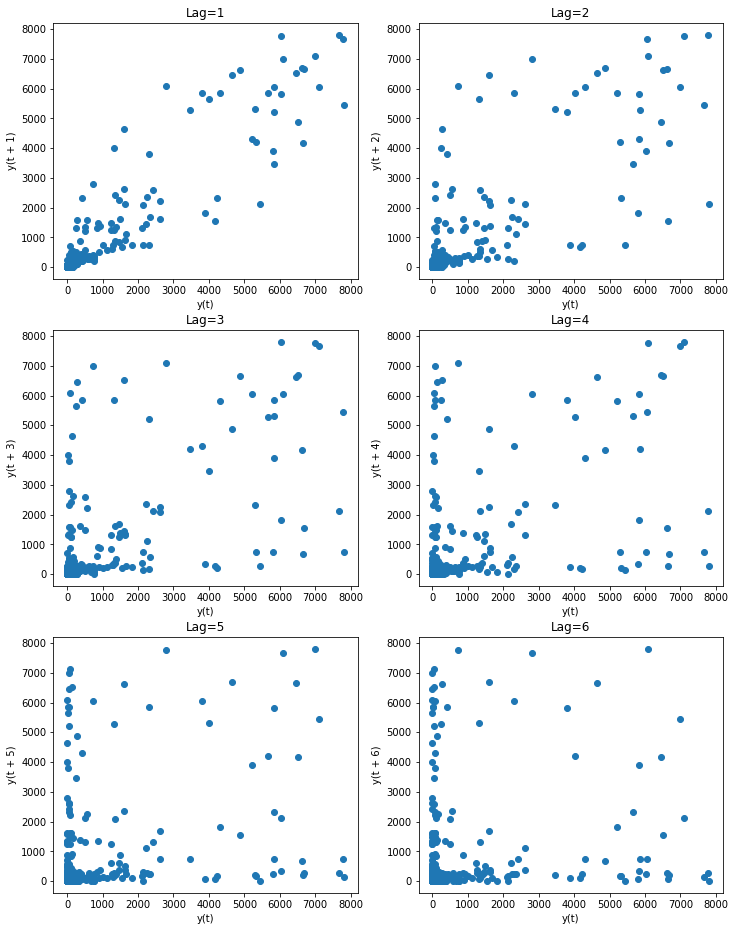

In [18]:
from pandas.plotting import lag_plot

fig, axes = plt.subplots(3, 2, figsize=(12, 16))
plt.title('Autocorrelation plot')

# The axis coordinates for the plots
ax_idcs = [
    (0, 0),
    (0, 1),
    (1, 0),
    (1, 1),
    (2, 0),
    (2, 1)
]

for lag, ax_coords in enumerate(ax_idcs, 1):
    ax_row, ax_col = ax_coords
    axis = axes[ax_row][ax_col]
    lag_plot(df.iloc[:, 1], lag=lag, ax=axis)
    axis.set_title(f"Lag={lag}")
    
plt.show()

### Estimating the differencing term

We can estimate the best lag term with several statistical tests:

In [19]:
from pmdarima.arima import ndiffs

kpss_diffs = ndiffs(y_train, alpha=0.05, test='kpss', max_d=6)
adf_diffs = ndiffs(y_train, alpha=0.05, test='adf', max_d=6)
n_diffs = max(adf_diffs, kpss_diffs)

print(f"Estimated differencing term: {n_diffs}")

Estimated differencing term: 0


Use `auto_arima` to fit a model on the data.

In [20]:
auto = pm.auto_arima(y_train, d=n_diffs, seasonal=False, stepwise=True,
                     suppress_warnings=True, error_action="ignore", max_p=6,
                     max_order=None, trace=True)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=8071.107, Time=0.34 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=9506.544, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8275.384, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=8901.729, Time=0.16 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=8069.729, Time=0.24 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=8482.923, Time=0.35 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=8140.720, Time=0.07 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=8071.019, Time=0.28 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=8272.613, Time=0.52 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=8100.574, Time=0.08 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=8072.706, Time=0.57 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=8067.397, Time=0.82 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=8451.276, Time=0.76 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=8140.026, Time=0.50 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept

In [21]:
print(auto.order)

(1, 0, 2)


In [22]:
from sklearn.metrics import mean_squared_error
from pmdarima.metrics import smape

model = auto

def forecast_one_step():
    fc, conf_int = model.predict(n_periods=1, return_conf_int=True)
    return (
        fc.tolist()[0],
        np.asarray(conf_int).tolist()[0])

forecasts = []
confidence_intervals = []

for new_ob in y_test:
    fc, conf = forecast_one_step()
    forecasts.append(fc)
    confidence_intervals.append(conf)
    
    # Updates the existing model with a small number of MLE steps
    model.update(new_ob)
    
print(f"Mean squared error: {mean_squared_error(y_test, forecasts)}")
print(f"SMAPE: {smape(y_test, forecasts)}")

Mean squared error: 285374.3130732871
SMAPE: 144.16104297564277


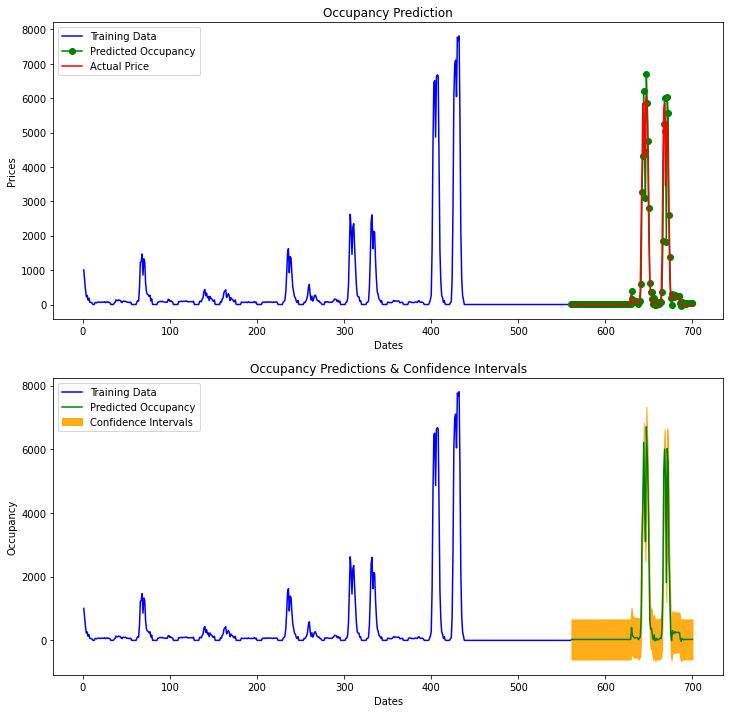

In [23]:
fig, axes = plt.subplots(2, 1, figsize=(12, 12))

# --------------------- Actual vs. Predicted --------------------------
axes[0].plot(y_train, color='blue', label='Training Data')
axes[0].plot(test_data.index, forecasts, color='green', marker='o',
             label='Predicted Occupancy')

axes[0].plot(test_data.index, y_test, color='red', label='Actual Price')
axes[0].set_title('Occupancy Prediction')
axes[0].set_xlabel('Dates')
axes[0].set_ylabel('Prices')

#axes[0].set_xticks(np.arange(0, 7982, 1300).tolist(), df['Date'][0:7982:1300].tolist())
axes[0].legend()


# ------------------ Predicted with confidence intervals ----------------
axes[1].plot(y_train, color='blue', label='Training Data')
axes[1].plot(test_data.index, forecasts, color='green',
             label='Predicted Occupancy')

axes[1].set_title('Occupancy Predictions & Confidence Intervals')
axes[1].set_xlabel('Dates')
axes[1].set_ylabel('Occupancy')

conf_int = np.asarray(confidence_intervals)
axes[1].fill_between(test_data.index,
                     conf_int[:, 0], conf_int[:, 1],
                     alpha=0.9, color='orange',
                     label="Confidence Intervals")

#axes[1].set_xticks(np.arange(0, 7982, 1300).tolist(), df['Date'][0:7982:1300].tolist())
axes[1].legend()